In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from ToyTrajectoryNet.utils import generate_steps, set_seeds, config_criterion
from ToyTrajectoryNet.models import make_model, Autoencoder
from ToyTrajectoryNet.plots import plot_comparision, plot_losses
from ToyTrajectoryNet.train import train_ae, training_regimen
from ToyTrajectoryNet.constants import ROOT_DIR, DATA_DIR, NTBK_DIR, IMGS_DIR, RES_DIR
from ToyTrajectoryNet.datasets import (
    make_diamonds, make_swiss_roll, make_tree, make_eb_data, 
    make_dyngen_data
)
from ToyTrajectoryNet.geo import setup_distance
from ToyTrajectoryNet.exp import setup_exp
from ToyTrajectoryNet.eval import generate_plot_data

import os, pandas as pd, numpy as np, \
    seaborn as sns, matplotlib as mpl, matplotlib.pyplot as plt, \
    torch, torch.nn as nn

from tqdm.notebook import tqdm
import time

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load dataset

In [2]:
phate_dims = 5
df = make_dyngen_data(phate_dims=phate_dims)

Calculating PHATE...
  Running PHATE on 1000 observations and 135 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.12 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.24 seconds.
    Calculating affinities...
    Calculated affinities in 0.04 seconds.
  Calculated graph and diffusion operator in 0.43 seconds.
  Calculating optimal t...
    Automatically selected t = 12
  Calculated optimal t in 1.73 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.83 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 41.66 seconds.
Calculated PHATE in 44.68 seconds.


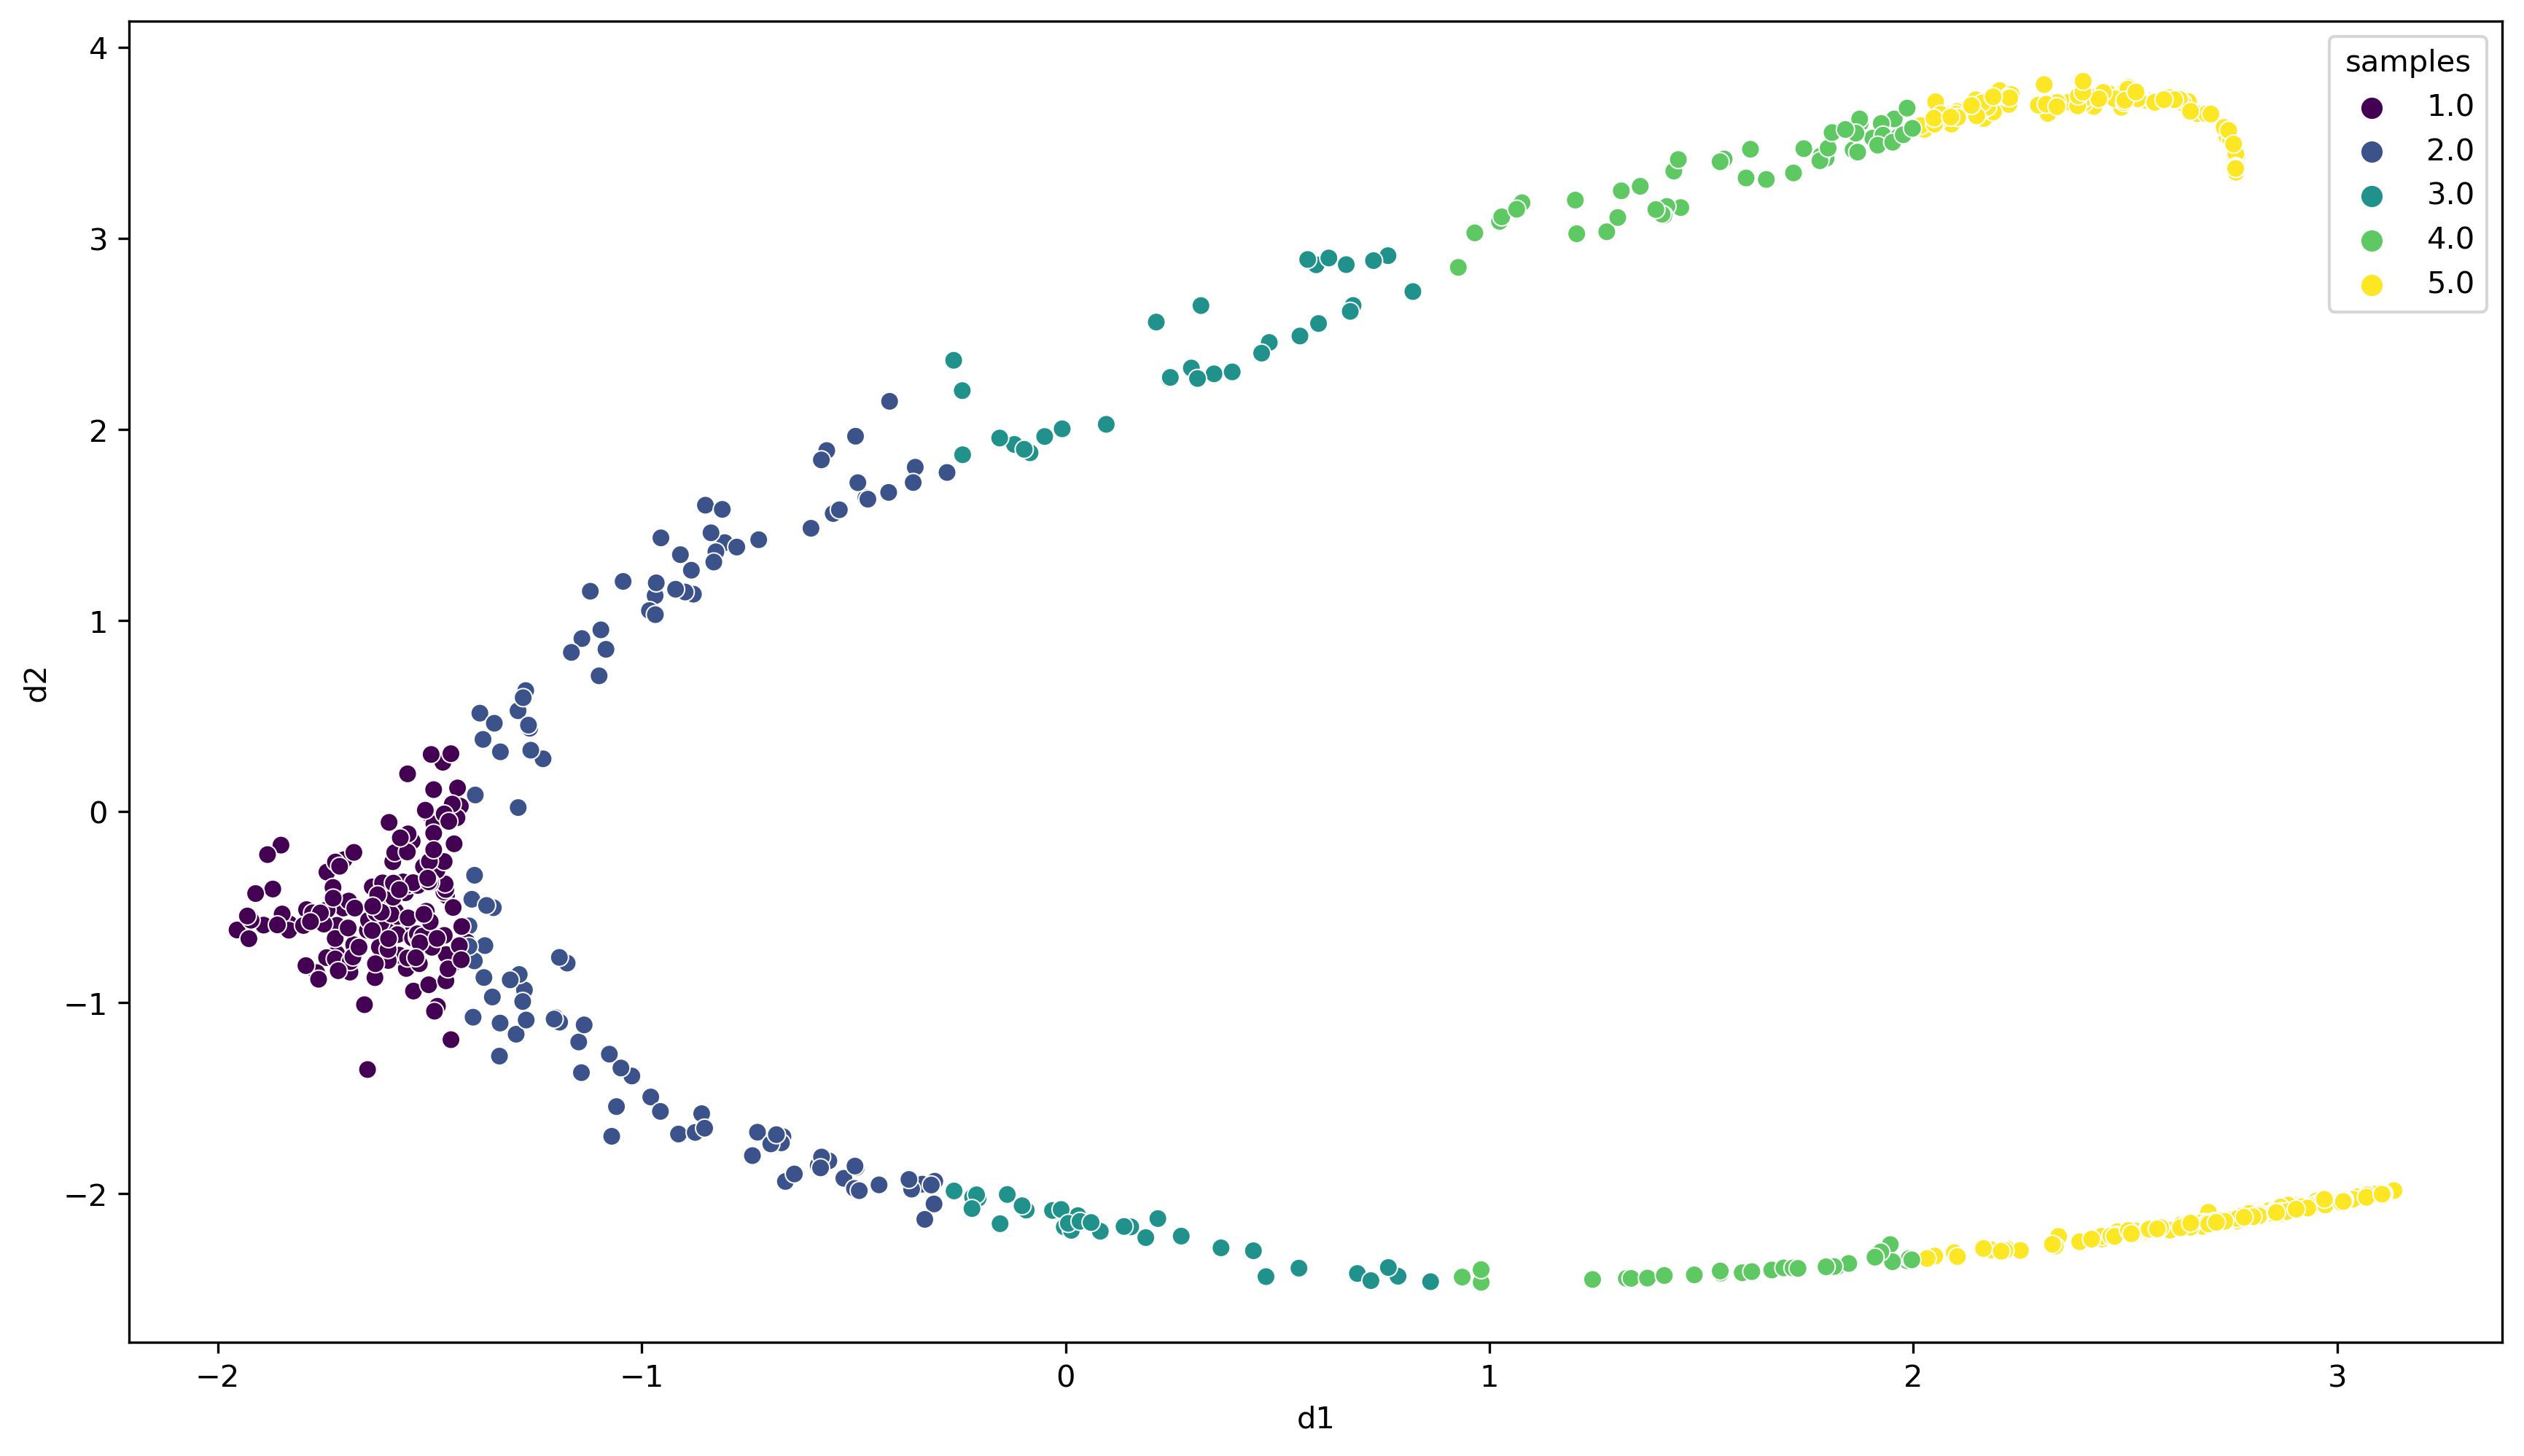

In [4]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis');

# Train autoencoder or the geodesic embedding

#### Set seeds and check GPU

In [299]:
set_seeds(0)
use_cuda = torch.cuda.is_available()

#### Handle hold-out training condition

In [300]:
# This is True if we want to holdout (or skip) one timepoint during training. It is used to test the accuracy of the trajectories on unseen data.
hold_one_out = False
# It can be a group number or 'random', works in tandem with hold_one_out
hold_out = 3

# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples".
model_features = len(df.columns) - 1
groups = sorted(df.samples.unique())

In [301]:
# These determine the logic flow for training: 
#   use_emb=True use_gae=False is only the encoder to match the approximation of the geodesic.
#   use_emb=False use_gae=True the full Geodesic Autoencoder (GAE), i.e. matching the geodesic and a reconstruction loss.
#   use_emb=False use_gae=False Is not using the GAE.
#   use_emb=True use_gae=True, is redundant and should raise an error. 
use_emb = False
use_gae = True

need_to_train_gae = (use_emb or use_gae) and use_emb != use_gae

# If the reconstruction loss needs to be computed.
recon = use_gae and not use_emb 

# These are training GAE hyperparameters needed for training
# Distance_type in ['gaussian', 'alpha_decay'], and Gaussian scale
distance_type = 'alpha_decay'
rbf_length_scale=0.05
knn=5
dist = setup_distance(distance_type, rbf_length_scale=rbf_length_scale, knn=knn)

#Can be changed depending on the dataset
n_epochs_emb = 1000
samples_size_emb = (30, )

# Layers for the Geodesic Autoencoder
gae_embedded_dim = 5
encoder_layers = [model_features, 32, gae_embedded_dim]

gae = Autoencoder(
    encoder_layers = encoder_layers,
    decoder_layers = encoder_layers[::-1],
    activation='ReLU', use_cuda = use_cuda
)
optimizer = torch.optim.AdamW(gae.parameters())

#### Actually train the GAE

In [302]:
# Added in extra cell just for iterative programming / running of code
#   but could be added to code block above

if need_to_train_gae:
    start_time_geo = time.time()

    losses = train_ae(
        gae, df, groups, optimizer, 
        n_epochs=n_epochs_emb, sample_size=samples_size_emb,
        noise_min_scale=0.009, noise_max_scale=0.015, 
        dist=dist, recon=recon, use_cuda=use_cuda,
        hold_one_out=hold_one_out, hold_out=hold_out
    )
    run_time_geo = time.time() - start_time_geo

    print(run_time_geo)
    autoencoder = gae
else:
    autoencoder = None

  0%|          | 0/1000 [00:00<?, ?it/s]

Train loss recon: 1.82132
Train loss dist: 22.96321
Train loss recon: 1.32893
Train loss dist: 10.40097
Train loss recon: 0.78929
Train loss dist: 8.93062
Train loss recon: 0.47202
Train loss dist: 7.64697
Train loss recon: 0.24584
Train loss dist: 7.18162
Train loss recon: 0.10169
Train loss dist: 6.97903
Train loss recon: 0.05535
Train loss dist: 5.98046
Train loss recon: 0.06697
Train loss dist: 5.25213
Train loss recon: 0.04305
Train loss dist: 5.18576
Train loss recon: 0.04551
Train loss dist: 4.82538
Train loss recon: 0.02277
Train loss dist: 4.46702
Train loss recon: 0.01441
Train loss dist: 4.70097
Train loss recon: 0.01099
Train loss dist: 4.26069
Train loss recon: 0.00838
Train loss dist: 4.38534
Train loss recon: 0.01046
Train loss dist: 4.39662
Train loss recon: 0.00819
Train loss dist: 4.32371
Train loss recon: 0.00738
Train loss dist: 4.27492
Train loss recon: 0.00851
Train loss dist: 4.36086
Train loss recon: 0.00718
Train loss dist: 4.28156
Train loss recon: 0.00746
Tra

# Specify parameters

In [284]:
set_seeds(10)

#Directory where results are saved
exp_name = 'dyngen_embcomp'

# density loss knn
use_density_loss = True

# Weight of density (not percentage of total loss)
lambda_density = 5

# For petal=LeakyReLU / dyngen=CELU
activation = 'CELU'

# Can change but we never really do, mostly depends on the dataset.
layers = [16,32,16]

# Scale of the noise in the trajectories. Either len(groups)*[float] or None. Should be None if using an adaptative ODE solver.
sde_scales = len(groups)*[0.2] 

if recon:    
    model_features = gae_embedded_dim

model = make_model(
    model_features, layers, 
    activation=activation, scales=sde_scales, use_cuda=use_cuda
)

In [285]:
# Basically "batch size"
sample_size=(60, )

# Training specification
n_local_epochs = 0
n_epochs = 50
n_post_local_epochs = 0

# Using the reverse trajectories to train
reverse_schema = False
# each reverse_n epoch
reverse_n = 2


criterion_name = 'ot'
criterion = config_criterion(criterion_name)

optimizer = torch.optim.AdamW(model.parameters())

# Bookkeeping variables
batch_losses = []
globe_losses = []
if hold_one_out and hold_out in groups:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups) if hold_out not in [t0, t1]}
else:
    local_losses = {f'{t0}:{t1}':[] for (t0, t1) in generate_steps(groups)}

# For creating output.
n_points = 100
n_trajectories = 100
n_bins = 100


In [286]:
opts = {
    'phate_dims': phate_dims,
    'use_cuda': use_cuda,
    'model_features': model_features,
    'exp_name': exp_name,
    'groups': groups,
    'sample_size': sample_size,
    'use_emb': use_emb,
    'n_local_epochs': n_local_epochs,
    'n_epochs': n_epochs,
    'n_post_local_epochs': n_post_local_epochs,
    'criterion_name': criterion_name,
    'hold_one_out': hold_one_out,
    'use_density_loss': use_density_loss,
    'n_points': n_points,
    'n_trajectories': n_trajectories,
    'n_bins': n_bins,
    'autoencoder': autoencoder,
    'activation_ode': activation,
    'layer': layers,
    'lambda_density':lambda_density,
    'use_gae': use_gae,
    'sde_scales': sde_scales,
    'hold_out':hold_out,
    'encoder_layers': encoder_layers,
    'n_epochs_emb': n_epochs_emb,
    'samples_size_emb': samples_size_emb,
    'recon': recon,
    'distance_type':distance_type,
    'rbf_length_scale':rbf_length_scale,
    'reverse_schema': reverse_schema,
    'reverse_n': reverse_n,
    'knn':knn
}

In [287]:
exp_dir, logger = setup_exp(RES_DIR, opts, exp_name) 

In [288]:
start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(
    # local, global, local train structure
    n_local_epochs=n_local_epochs, 
    n_epochs=n_epochs, 
    n_post_local_epochs=n_post_local_epochs,
    
    # where results are stored
    exp_dir=exp_dir, 

    # BEGIN: train params
    model=model, df=df, groups=groups, optimizer=optimizer, 
    criterion=criterion, use_cuda=use_cuda,
    
    hold_one_out=hold_one_out, hold_out=hold_out,
    
    use_density_loss=use_density_loss, 
    lambda_density=lambda_density,
    
    autoencoder=autoencoder, use_emb=use_emb, use_gae=use_gae, 
    
    sample_size=sample_size, logger=logger,
    reverse_schema=reverse_schema, reverse_n=reverse_n,
    # END: train params

    plot_every=5,
    n_points=n_points, n_trajectories=n_trajectories, n_bins=n_bins, 
    #local_losses=local_losses, batch_losses=batch_losses, globe_losses=globe_losses
)
run_time = time.time() - start_time + run_time_geo if use_emb or use_gae else time.time() - start_time
logger.info(f'Total run time: {np.round(run_time, 5)}')

Pretraining Epoch: 0it [00:00, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Posttraining Epoch: 0it [00:00, ?it/s]

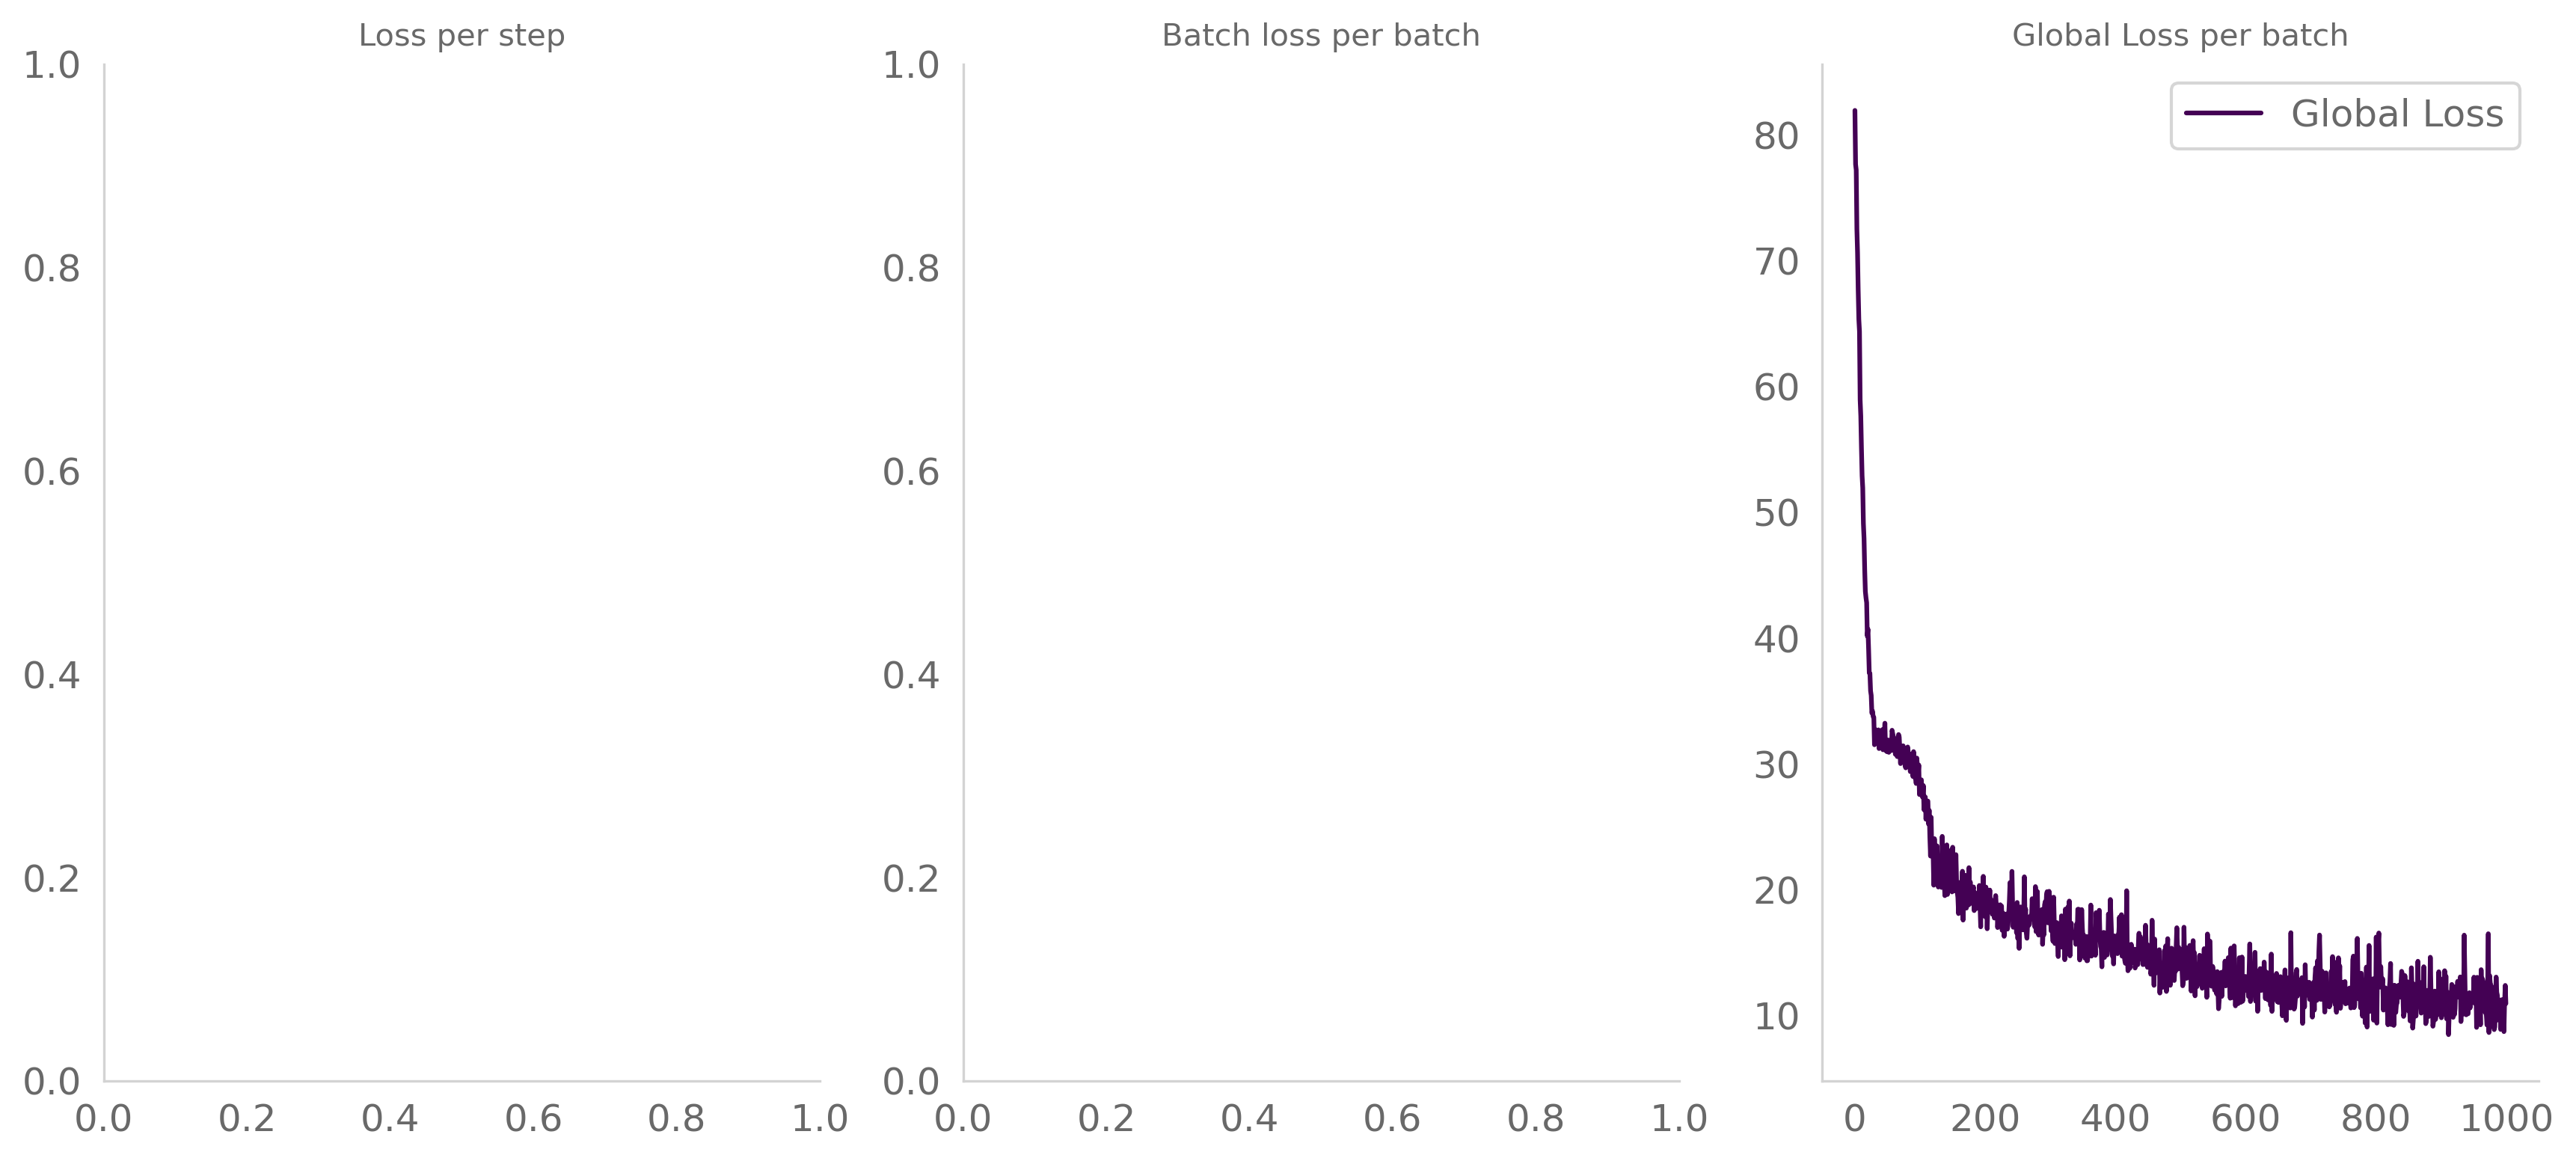

In [289]:
plot_losses(
    local_losses, batch_losses, globe_losses, 
    save=True, path=exp_dir, file='losses.png'
)

In [294]:
generated, trajectories = generate_plot_data(
    model, df, n_points, n_trajectories, n_bins, use_cuda=use_cuda, samples_key='samples', logger=logger,
    autoencoder=autoencoder, recon=recon
)

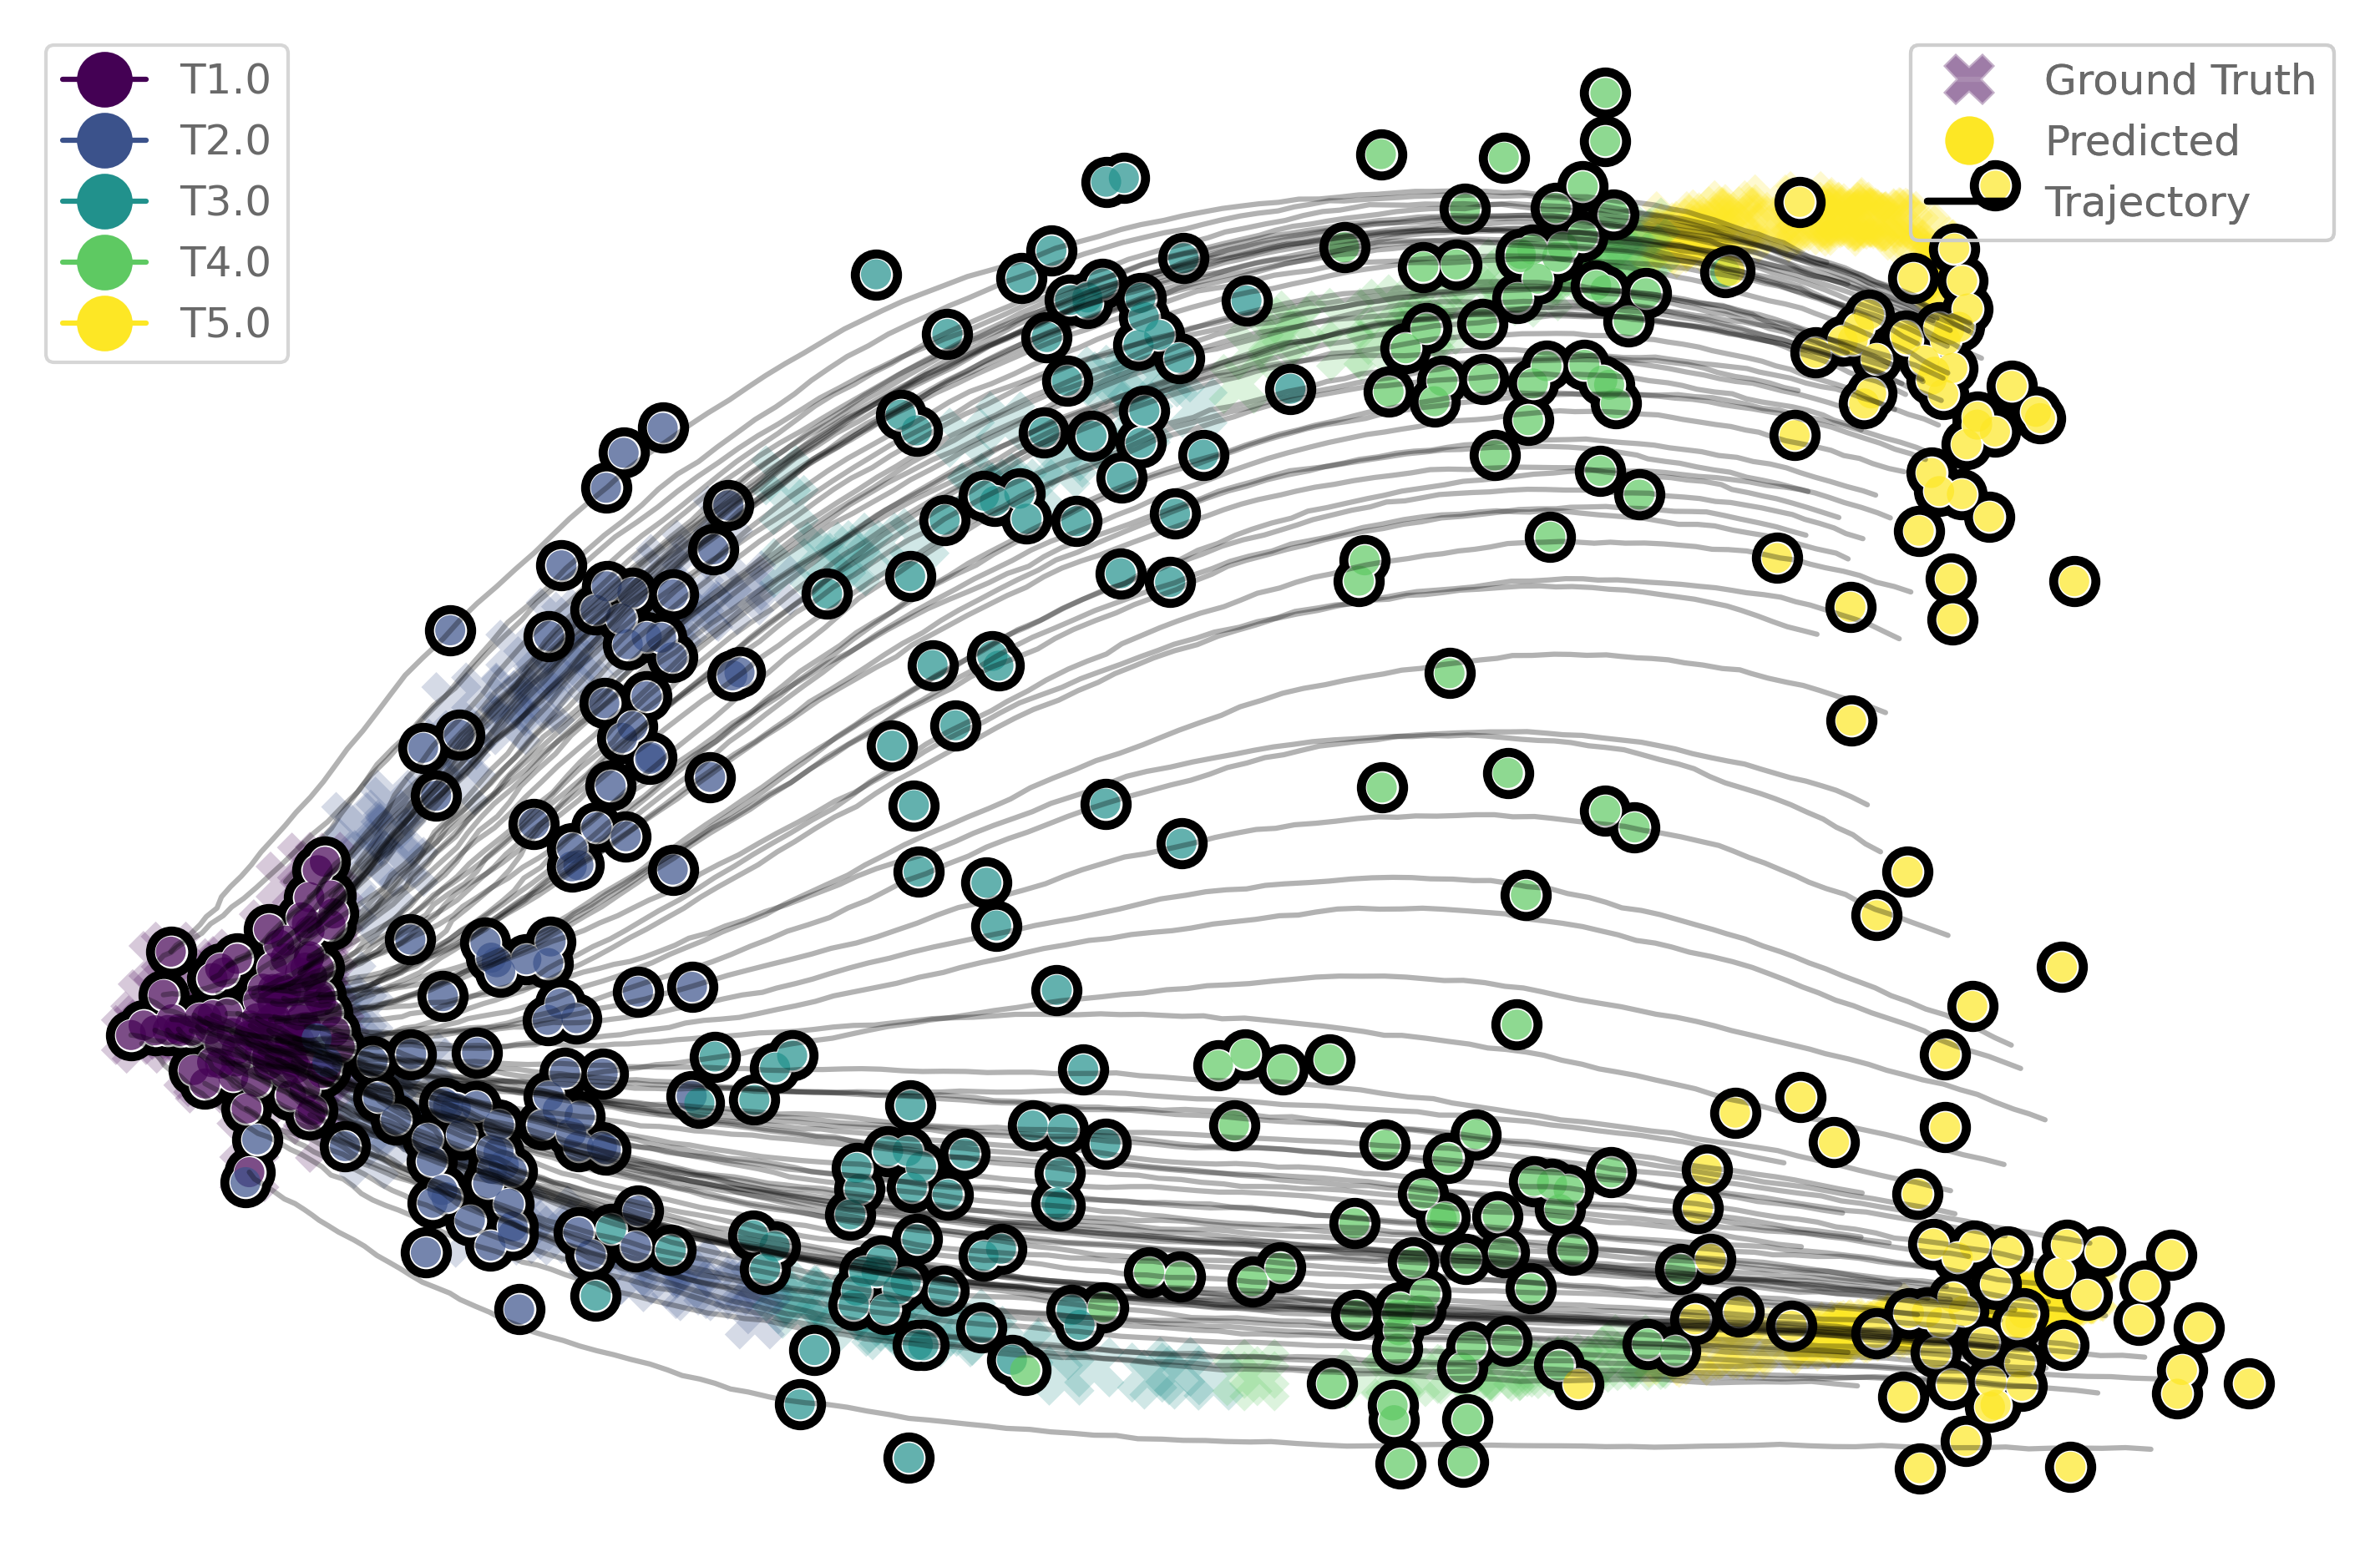

In [295]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='2d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=False
)

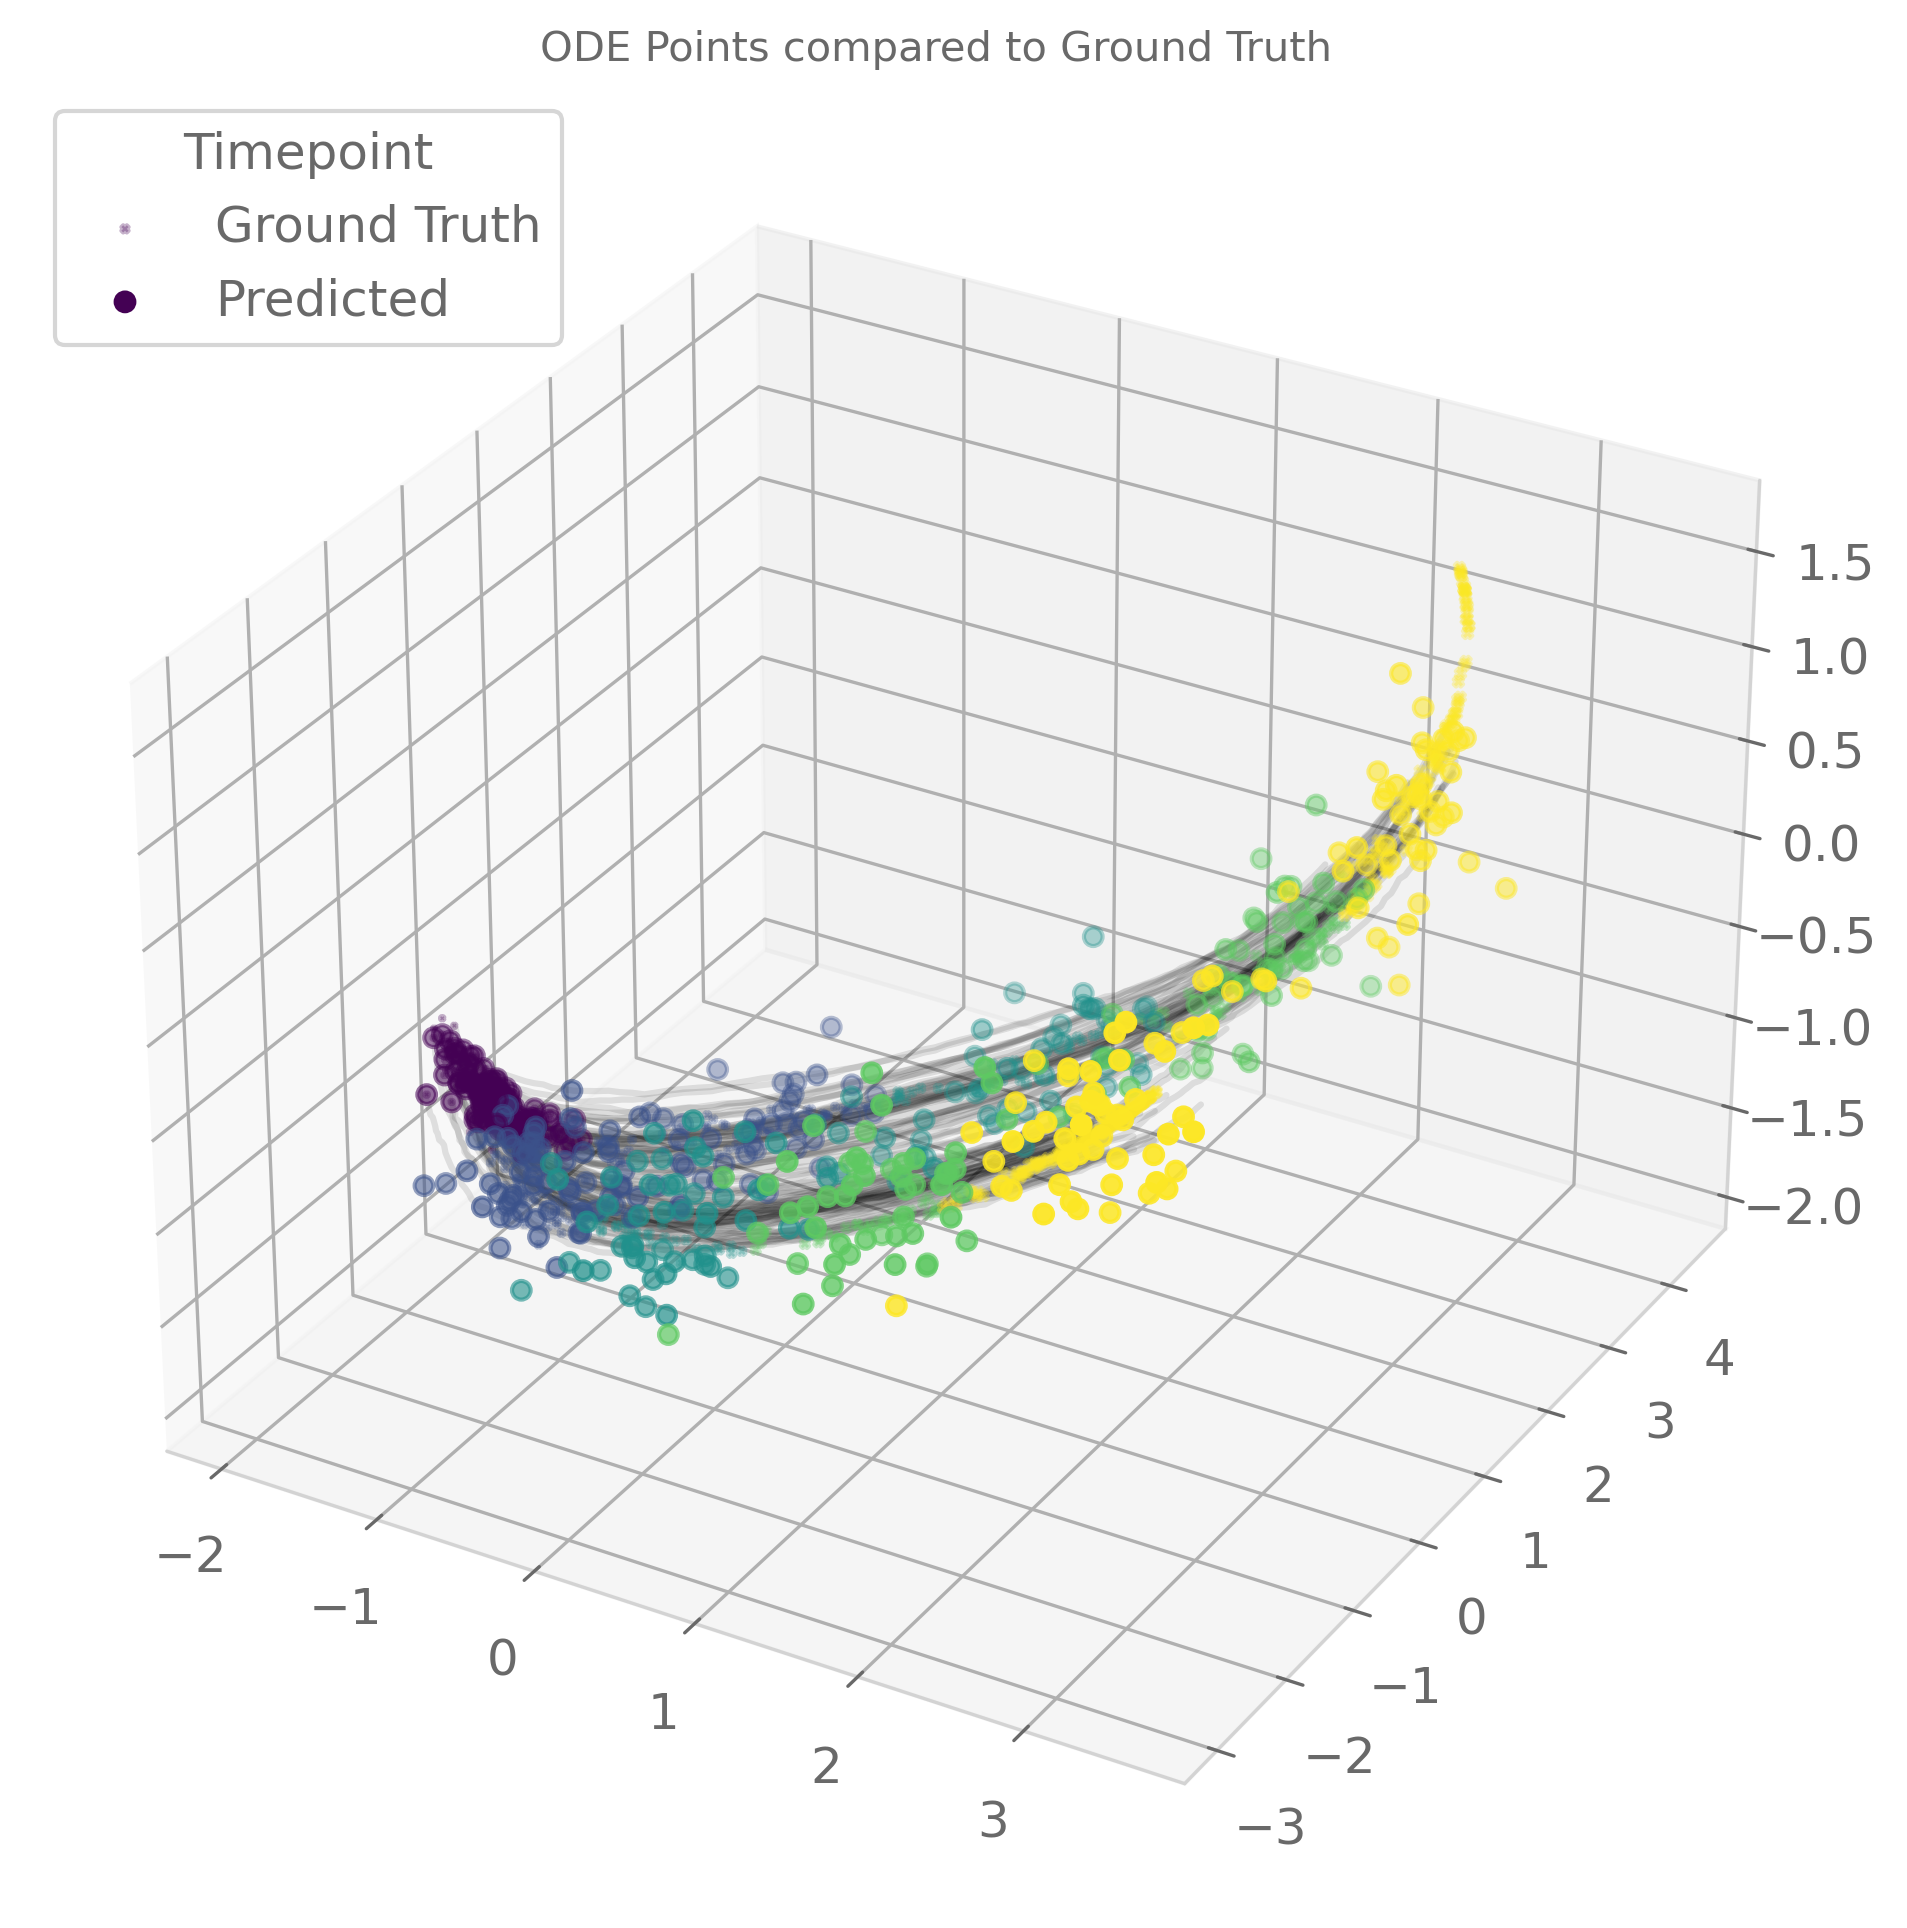

In [296]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='3d_comparision.png',
    x='d1', y='d2', z='d3', is_3d=True
)

In [298]:
# saving the trajectories and generated points
np.save(os.path.join(exp_dir,'trajectories_noemb.npy'),trajectories)
np.save(os.path.join(exp_dir,'generated_noemb.npy'),generated)

In [238]:
#Temporary fix for the logger
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

In [263]:
# To see the evolution of the scales before/after training. 
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)

In [279]:
from ToyTrajectoryNet.utils import group_extract, sample
import ot
from ToyTrajectoryNet.losses import MMD_loss
emd_loss = []
mmd_loss = []
for t in groups[1:]:
    set_seeds(10)
    xs = generated[int(t-1),:60]
    xt = sample(df,group=t,size=60)
    xs.shape,xt.shape
    a = torch.tensor(ot.unif(xs.shape[0]))
    b = torch.tensor(ot.unif(xt.shape[0]))
    M = ot.dist(xs, xt, metric='euclidean')
    emd_loss.append(ot.emd2(a, b, M))
    mmd = MMD_loss()
    mmd_loss.append(mmd.forward(torch.tensor(xs),torch.tensor(xt)))
f = open(exp_dir+"/metric.txt", "a")
f.write('\nAlpha 15 mean EMD :'+str(np.mean(emd_loss))+' MMD mean : '+str(np.mean(mmd_loss))+'\n')
f.close()